# Circumplanetary Dust

This example shows how to integrate circumplanetary dust particles under the action of radiation forces.  We use Saturn's Phoebe ring as an example, a distant ring of debris. 

We have to make sure we add all quantities in the same units.  Here we choose to use SI units.  We begin by adding the Sun and Saturn, and use Saturn's orbital plane as the reference plane:

In [1]:
import rebound
import reboundx
import numpy as np
sim = rebound.Simulation()
sim.G = 6.674e-11 # SI units
sim.dt = 1.e4 # Initial timestep in sec.
sim.N_active = 2 # Make it so dust particles don't interact with one another gravitationally
sim.add(m=1.99e30) # add Sun with mass in kg
sim.add(m=5.68e26, a=1.43e12, e=0.056, pomega = 0., f=0.) # Add Saturn at pericenter

Now let's set up `reboundx` and add `radiation_forces`.  We have to pass both the speed of light and the luminosity of the star (in m/s and W for our units):

In [2]:
rebx = reboundx.Extras(sim)
rebx.add_radiation_forces(c=3.e8, L=3.85e26)

**In order for particles to feel radiation forces, they have to have their radiation pressure coefficient `Q_pr` set**.  For particles whose size is >> the stellar radiation, `Q_pr = 1`.  **Additionally, we have to specify the particles' mass and radius**.  Here we just show how to add two dust grains in different ways.  In both cases we assume a particular density and use some simple REBOUNDx convenience functions.

We assume particles come from Saturn's irregular satellite Phoebe.  Since the escape speed from Phoebe is << the satellite's orbital speed, dust grains will inherits their parent body's orbital elements:

In [3]:
a = 1.3e10 # m
e = 0.16
inc = 175*np.pi/180.
Omega = 0.
omega = 0.
f = 0.

Saturn = sim.particles[1]
# Add two dust grains with same initial conditions (they don't interact so this is OK),
# with orbital elements referenced to Saturn
sim.add(primary=Saturn, a=a, e=e, inc=inc, Omega=Omega, omega=omega, f=f)
sim.add(primary=Saturn, a=a, e=e, inc=inc, Omega=Omega, omega=omega, f=f)

# Set particle properties
Q_pr = 1.
density = 1000. # kg/m^3 = 1g/cc

p1 = sim.particles[2]
p2 = sim.particles[3]

For the first particle we simply specify the radius, and then calculate the mass from the density:

In [4]:
p1.r = 1.e-5 # grain radius in m
p1.m = rebx.rad_calc_mass(density, p1.r) # simple function assumes spherical grains
p1.Q_pr = Q_pr

For the second particle, we specify a `beta` parameter, the ratio of the radiation pressure force to the gravitational force from the star (Burns et al. 1979), and use the density to calculate the radius:

In [5]:
beta = 0.01
p2.r = rebx.rad_calc_particle_radius(beta, density, Q_pr)
p2.m = rebx.rad_calc_mass(density, p2.r) 
p2.Q_pr = Q_pr

Now let's run for 100 years (about 3 Saturn orbits), and look at how the eccentricity varies over a Saturn year:

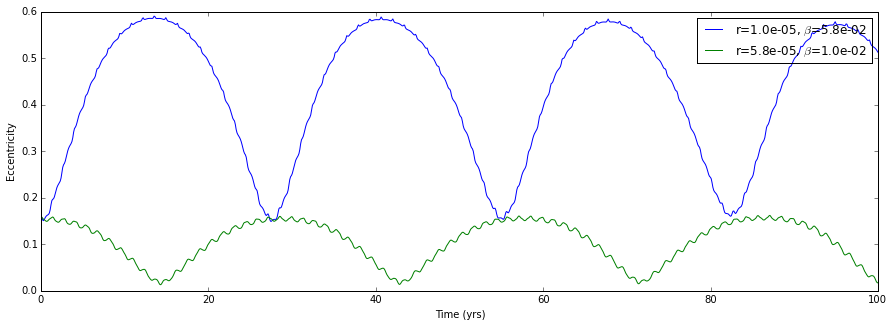

In [6]:
yr = 365*24*3600 # s
Noutput = 1000
times = np.linspace(0,100.*yr, Noutput)
e1, e2 = np.zeros(Noutput), np.zeros(Noutput)

sim.move_to_com() # move to center of mass frame first

for i, time in enumerate(times):
    sim.integrate(time)
    e1[i] = p1.calculate_orbit(primary=Saturn).e
    e2[i] = p2.calculate_orbit(primary=Saturn).e
   
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))

ax.plot(times/yr, e1, label=r"r={0:.1e}, $\beta$={1:.1e}".format(p1.r, rebx.rad_calc_beta(p1)))
ax.plot(times/yr, e2, label=r"r={0:.1e}, $\beta$={1:.1e}".format(p2.r, rebx.rad_calc_beta(p2)))
ax.set_xlabel('Time (yrs)')
ax.set_ylabel('Eccentricity')
plt.legend()